# Price Prediction Modeling Notebook

In [1]:
# Load in libraries
import warnings
from importlib import reload

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np 

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as sms

from statsFunctions import check_model
from statsFunctions import plot_residuals

from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns

In [2]:
# load in data
df = pd.read_csv('../data/prepped_for_price_prediction.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view_rank,...,sqft_living15,sqft_lot15,bed_bath_ratio,date_month,date_day,date_year,renovated_status,sqft_living15_diff,sqft_lot15_diff,scenic_status
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,...,1340,5650,3.000000,10,13,2014,UNK,-160,0,N
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,...,1690,7639,1.333333,12,9,2014,Y,880,-397,N
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,...,2720,8062,2.000000,2,25,2015,UNK,-1950,1938,N
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0,...,1360,5000,1.333333,12,9,2014,UNK,600,0,N
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0,...,1800,7503,1.500000,2,18,2015,UNK,-120,577,N


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21015 entries, 0 to 21014
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  21015 non-null  int64  
 1   date                21015 non-null  object 
 2   price               21015 non-null  float64
 3   bedrooms            21015 non-null  int64  
 4   bathrooms           21015 non-null  float64
 5   sqft_living         21015 non-null  int64  
 6   sqft_lot            21015 non-null  int64  
 7   floors              21015 non-null  float64
 8   waterfront          21015 non-null  int64  
 9   view_rank           21015 non-null  int64  
 10  condition           21015 non-null  int64  
 11  grade               21015 non-null  int64  
 12  sqft_above          21015 non-null  int64  
 13  sqft_basement       21015 non-null  int64  
 14  yr_built            21015 non-null  int64  
 15  yr_renovated        21015 non-null  int64  
 16  zipc

## Explore the feature space

In [56]:
# Trying to predict price
target = 'price'

In [57]:
# let's find some features based on their correlation scores

def get_columns_correlations(df, target):
    columns_correlations = []
    columns_non_numeric = []
    
    for column in df.drop(columns=[target]).columns:
        try:
            # using .corr on each column to the target
            corr = np.abs(df[column].corr(df[target]))
            t = (column, corr)
            columns_correlations.append(t)
        except:
            columns_non_numeric.append(column)
    return columns_correlations


def get_columns_correlations_above_threshold(all_col_corrs):
    correlated_features_above_2 = [t[0] for t in all_col_corrs if t[1] >= 0.20]
    return correlated_features_above_2

In [58]:
all_columns_correlations = get_columns_correlations(df, target)
all_columns_correlations

[('id', 0.0049713657034335555),
 ('bedrooms', 0.32009275808641063),
 ('bathrooms', 0.4943660137462394),
 ('sqft_living', 0.6637915634182177),
 ('sqft_lot', 0.0911794593701834),
 ('floors', 0.2761483780214564),
 ('waterfront', 0.09917913866146054),
 ('view_rank', 0.314646078087731),
 ('condition', 0.03409147476646681),
 ('grade', 0.670889549861351),
 ('sqft_above', 0.5657588805938002),
 ('sqft_basement', 0.27422736168728384),
 ('yr_built', 0.05677582737729117),
 ('yr_renovated', 0.10043774306836302),
 ('zipcode', 0.029764637627550137),
 ('lat', 0.38490216168608005),
 ('long', 0.04397360518741762),
 ('sqft_living15', 0.5936346633797787),
 ('sqft_lot15', 0.0876422854129928),
 ('bed_bath_ratio', 0.2553764450449402),
 ('date_month', 0.008911805447362453),
 ('date_day', 0.011032497615754219),
 ('date_year', 0.0005214625815817166),
 ('sqft_living15_diff', 0.30144364029015136),
 ('sqft_lot15_diff', 0.04624974775810661)]

In [59]:
# let's get all columns with correlation above a threshold of 0.20
correlated_features_above_2 = [t[0] for t in all_columns_correlations if t[1] >= 0.20]
correlated_features_above_2

['bedrooms',
 'bathrooms',
 'sqft_living',
 'floors',
 'view_rank',
 'grade',
 'sqft_above',
 'sqft_basement',
 'lat',
 'sqft_living15',
 'bed_bath_ratio',
 'sqft_living15_diff']

In [60]:
whole_feature_space = correlated_features_above_2
whole_feature_space.append(target)

In [61]:
# Let's hone in on these promising features
correlated_df = df[whole_feature_space]
correlated_df.head()

,bedrooms,bathrooms,sqft_living,floors,view_rank,grade,sqft_above,sqft_basement,lat,sqft_living15,bed_bath_ratio,sqft_living15_diff,price
0,3,1.00,1180,1.0,0,7,1180,0,47.5112,1340,3.000000,-160,221900.0
1,3,2.25,2570,2.0,0,7,2170,400,47.7210,1690,1.333333,880,538000.0
2,2,1.00,770,1.0,0,6,770,0,47.7379,2720,2.000000,-1950,180000.0
3,4,3.00,1960,1.0,0,7,1050,910,47.5208,1360,1.333333,600,604000.0
4,3,2.00,1680,1.0,0,8,1680,0,47.6168,1800,1.500000,-120,510000.0


### Plot a scatter matrix for more insight

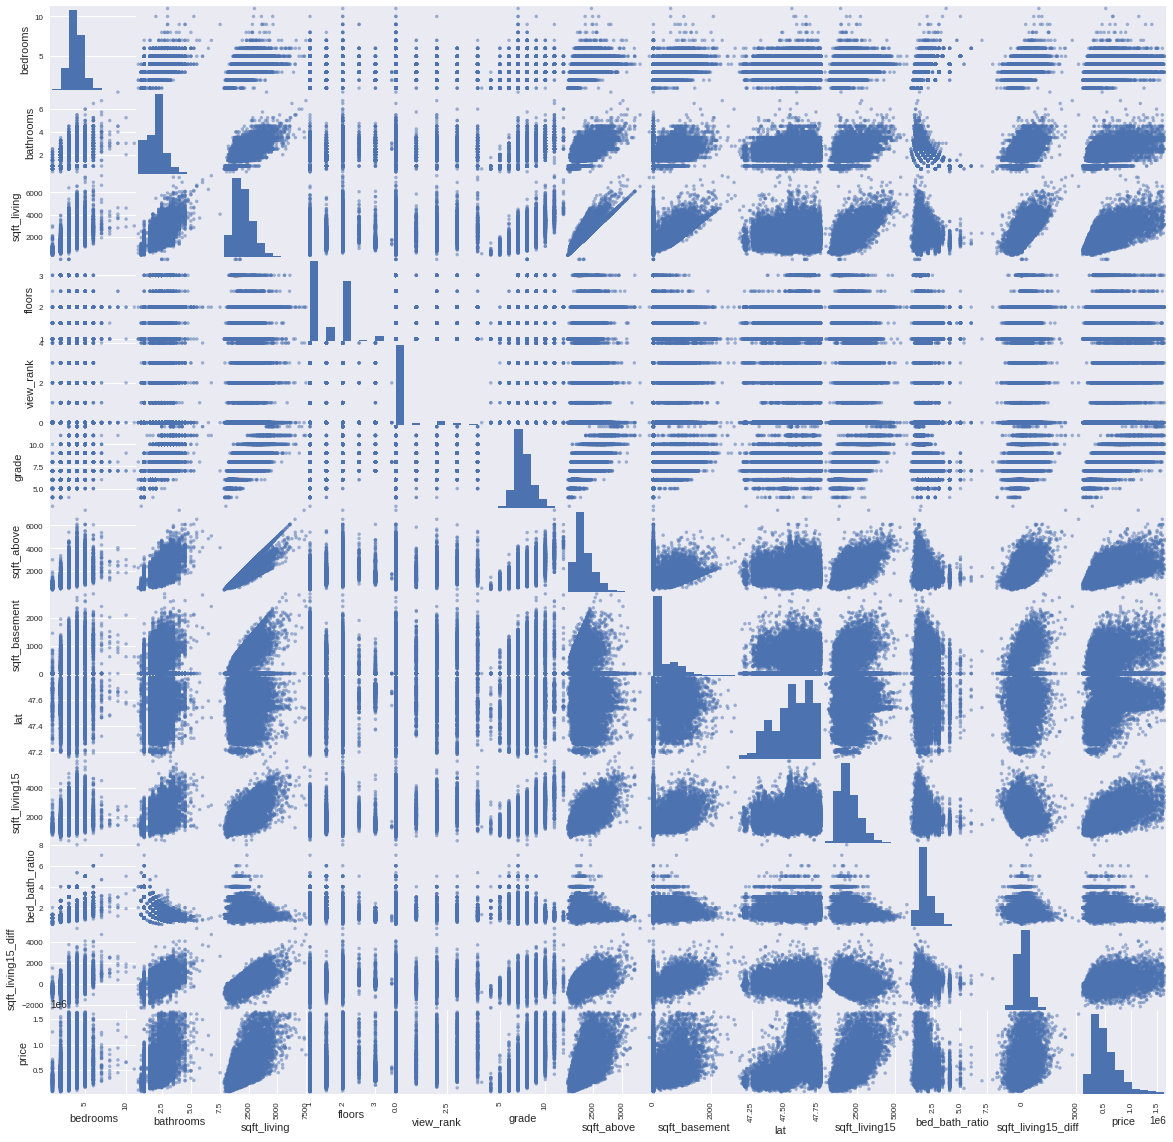

In [62]:
pd.plotting.scatter_matrix(correlated_df, figsize=(20,20))
plt.show()

### Apply log transforms on our skewed continuous variables.
* price (our target)
* sqft_living15
* lat
* sqft_basement
* sqft_above
* sqft_living
* bed_bath_ratio

__NOTE__ Distribution for __sqft_living15_diff__ is skewed but it has negative values so we can't try to use log transform to address skew. __OMIT__ from list of continous variables moving forward.


### Categorical variables to include:
* floors
* view_rank
* waterfront
* grade

__NOTE__ I created a new continous variable, __bed_bath_ratio__ to use instead of bedrooms, bathrooms.

<function matplotlib.pyplot.show(close=None, block=None)>

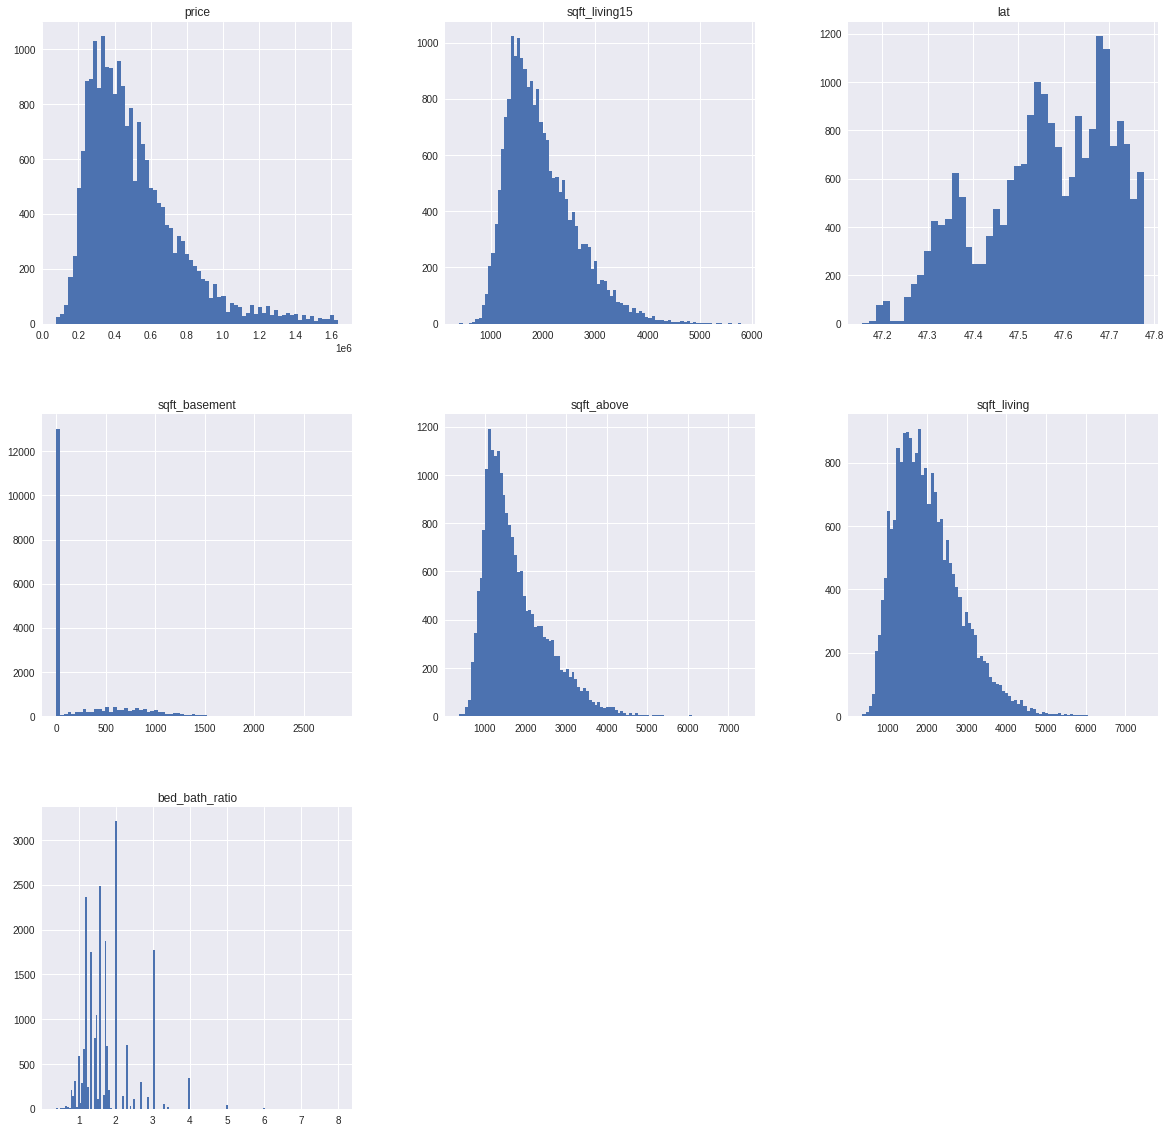

In [66]:
continuous_col_names = ['price','sqft_living15', 'lat', 'sqft_basement', 
                        'sqft_above', 'sqft_living', 'bed_bath_ratio']
continuous_df = correlated_df[continuous_col_names]
continuous_df.hist(figsize=[20, 20], bins='auto')
plt.show

#### Note that sqft_basement has a huge number of zeros. 
Drop this zero-inflated variable for now and just use the features which don't have this characteristic.

In [67]:
# Drop sqft_basement zero-inflated variable
continuous_df.drop(['sqft_basement'], axis=1, inplace=True)
continuous_df.head()

,price,sqft_living15,lat,sqft_above,sqft_living,bed_bath_ratio
0,221900.0,1340,47.5112,1180,1180,3.000000
1,538000.0,1690,47.7210,2170,2570,1.333333
2,180000.0,2720,47.7379,770,770,2.000000
3,604000.0,1360,47.5208,1050,1960,1.333333
4,510000.0,1800,47.6168,1680,1680,1.500000


### Perform log transformations for those variables that need skew correction
Recall that a common option for transforming non-normal variable distributions is to try applying a logarithmic function and observe its impact of the distribution.

In [68]:
# Now select those variables that need skew correction
non_norm_col_names = ['price','sqft_living15', 'lat', 'sqft_above', 'sqft_living', 'bed_bath_ratio']
non_norm_df = continuous_df[non_norm_col_names]

In [69]:
log_names = [f'{column}_log' for column in non_norm_df.columns]
cont_log_transformed_df = np.log(non_norm_df)
cont_log_transformed_df.columns = log_names
cont_log_transformed_df.head()

,price_log,sqft_living15_log,lat_log,sqft_above_log,sqft_living_log,bed_bath_ratio_log
0,12.309982,7.200425,3.860965,7.073270,7.073270,1.098612
1,13.195614,7.432484,3.865372,7.682482,7.851661,0.287682
2,12.100712,7.908387,3.865726,6.646391,6.646391,0.693147
3,13.311329,7.215240,3.861168,6.956545,7.580700,0.287682
4,13.142166,7.495542,3.863186,7.426549,7.426549,0.405465


<function matplotlib.pyplot.show(close=None, block=None)>

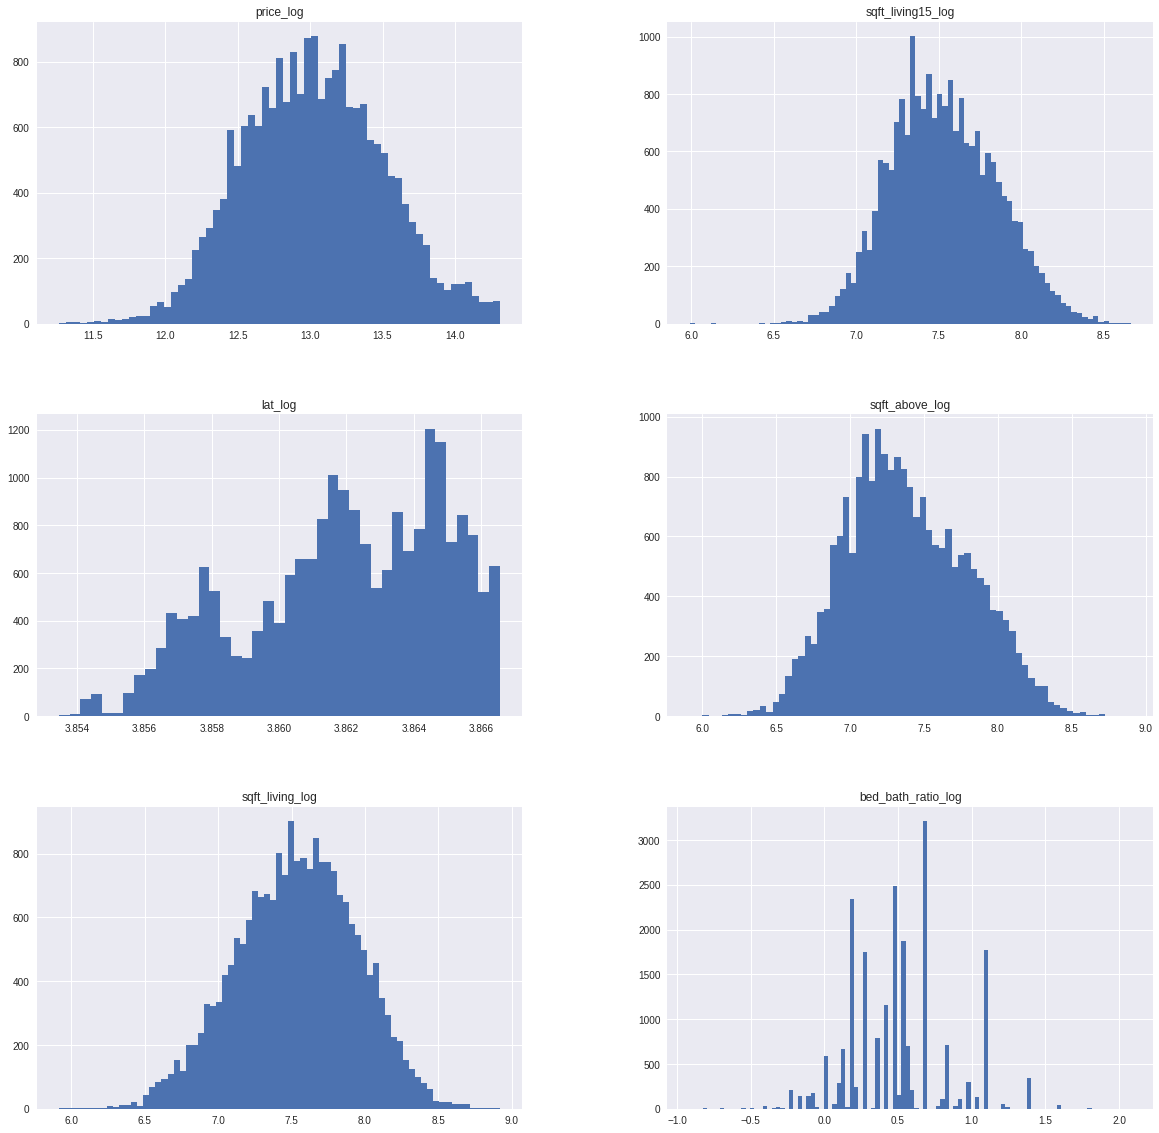

In [70]:
cont_log_transformed_df.hist(figsize=(20, 20), bins='auto')
plt.show

### Inspect the log transformed continuous variable distributions.  If the skew was improved, that variable will be standardized and  included in the final feature space/set.
* lat_log - NO improvement - DROP IT
* everything else - IMPROVED

In [71]:
# normalize function for features that were log transformed
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

# drop feature that didn't see skew improvement
cont_log_transformed_df.drop(['lat_log'], axis=1, inplace=True)
cont_log_transformed_df = cont_log_transformed_df.apply(normalize)

<function matplotlib.pyplot.show(close=None, block=None)>

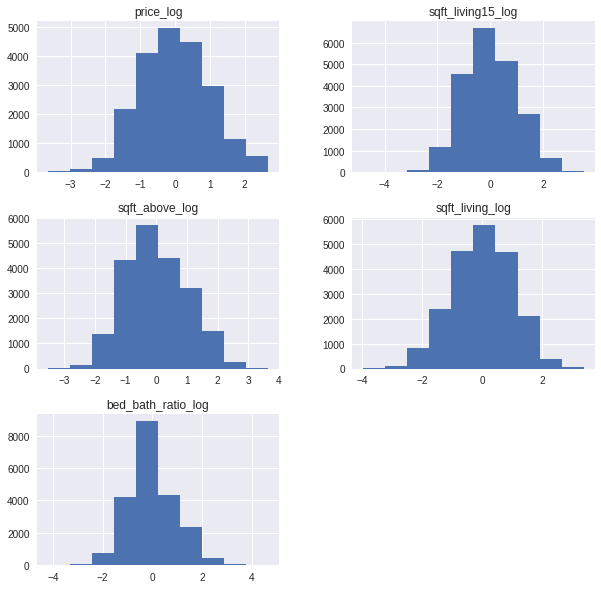

In [72]:
cont_log_transformed_df.hist(figsize=(10, 10))
plt.show


### One-hot-encode "useful' Categorical variables.

 #### > 0.20 Correlation threshold Categorical variables are:
* floors   ('floors', 0.2761483780214564),
* view_rank  ('view_rank', 0.314646078087731),
* grade ('grade', 0.670889549861351)

#### Don't fall into the Dummy Trap :)

In [73]:
# one-hot encode the categorical variables
categorical_col_names = ['floors', 'view_rank', 'grade']
corr_cat_df = correlated_df[categorical_col_names]
corr_cat_df.head()

,floors,view_rank,grade
0,1.0,0,7
1,2.0,0,7
2,1.0,0,6
3,1.0,0,7
4,1.0,0,8


In [75]:
# DON'T FALL INTO THE DUMMY TRAP!  drop_first=True :)
corr_ohe_df = pd.get_dummies(corr_cat_df, columns=categorical_col_names, prefix=categorical_col_names, drop_first=True)
corr_ohe_df.head()

,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,view_rank_1,view_rank_2,view_rank_3,view_rank_4,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [76]:
### concat the continous and categorical likely features into a single datafame for model creation
likely_features_df = pd.concat([cont_log_transformed_df, corr_ohe_df], axis = 1)
likely_features_df.head()

,price_log,sqft_living15_log,sqft_above_log,sqft_living_log,bed_bath_ratio_log,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,...,view_rank_4,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12
0,-1.481199,-1.030563,-0.742988,-1.128712,1.759623,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0.359789,-0.304710,0.724587,0.769794,-0.644586,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,-1.916215,1.183860,-1.771327,-2.169876,0.557518,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0.600330,-0.984223,-1.024173,0.108916,-0.644586,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0.248685,-0.107471,0.108051,-0.267060,-0.295388,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [77]:
list(likely_features_df.columns)

['price_log',
 'sqft_living15_log',
 'sqft_above_log',
 'sqft_living_log',
 'bed_bath_ratio_log',
 'floors_1.5',
 'floors_2.0',
 'floors_2.5',
 'floors_3.0',
 'floors_3.5',
 'view_rank_1',
 'view_rank_2',
 'view_rank_3',
 'view_rank_4',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12']

In [78]:
likely_feature_names = [
'sqft_living15_log',
'sqft_above_log',
'sqft_living_log',
'bed_bath_ratio_log',
'floors_1.5',
'floors_2.0',
'floors_2.5',
'floors_3.0',
'floors_3.5',
'view_rank_1',
'view_rank_2',
'view_rank_3',
'view_rank_4',
'grade_4',
'grade_5',
'grade_6',
'grade_7',
'grade_8',
'grade_9',
'grade_10',
'grade_11',
'grade_12'
]

### Now that we've got some likely features (continous variables that have been transformed and normalized and categorical variables that have been one-hot-encoded), create another model

In [79]:
ols = check_model(likely_features_df, features_to_use=likely_feature_names, 
                  target_col='price_log', show_summary=True)

sqft_above_log surpassed threshold with vif=5.915003408090275
sqft_living_log surpassed threshold with vif=5.044020101516336
Model contains multicollinear features
                                 OLS Regression Results                                
Dep. Variable:              price_log   R-squared (uncentered):                   0.549
Model:                            OLS   Adj. R-squared (uncentered):              0.549
Method:                 Least Squares   F-statistic:                              1163.
Date:                Fri, 16 Oct 2020   Prob (F-statistic):                        0.00
Time:                        17:33:48   Log-Likelihood:                         -21444.
No. Observations:               21015   AIC:                                  4.293e+04
Df Residuals:                   20993   BIC:                                  4.311e+04
Df Model:                          22                                                  
Covariance Type:            nonrobust       

### This new model has multicollinearity. Remove sqft_above_log feature and rerun.
sqft_above_log surpassed threshold with vif=5.915003408090275

In [104]:
likely_feature_names = [
'sqft_living15_log',
'sqft_living_log',
'bed_bath_ratio_log',
'floors_1.5',
'floors_2.0',
'floors_2.5',
'floors_3.0',
#'floors_3.5',  # removed 3.5 as a previous model showed p-value above 0.05 cutoff
'view_rank_1',
'view_rank_2',
'view_rank_3',
'view_rank_4',
'grade_4',
'grade_5',
'grade_6',
'grade_7',
'grade_8',
'grade_9',
'grade_10',
'grade_11',
'grade_12'
]

In [105]:
ols_round_2 = check_model(likely_features_df, features_to_use=likely_feature_names, 
                          target_col='price_log', show_summary=True)

                                 OLS Regression Results                                
Dep. Variable:              price_log   R-squared (uncentered):                   0.541
Model:                            OLS   Adj. R-squared (uncentered):              0.541
Method:                 Least Squares   F-statistic:                              1238.
Date:                Fri, 16 Oct 2020   Prob (F-statistic):                        0.00
Time:                        21:09:38   Log-Likelihood:                         -21633.
No. Observations:               21015   AIC:                                  4.331e+04
Df Residuals:                   20995   BIC:                                  4.347e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

### Let's consider a few of the coeffcients
* __sqft_living_log__ has coef of 0.2683, this matches our intution that larger living areas would have a positive coorelation to __price__.
* __view_rank_4__ has a coef of 0.7664, this matchs our intution that homes with very nice views (4 is the higest view rank) would have a positive correlation to __price__.
*__grade_4__ and __grade_12__, have coefs of -1.0711 and 1.2546, homes with a Grade value below 6 __don't__ meet the King County building code so no surprise that there is a negative correlation to __price__ while homes a Grade value of 12 are mansion level quality so no surprise that there is positive correlation to __price__.

#### All of the features have p-values that indicate the features are significant (with a cutoff of 0.05)

####  Plot to observe  if residuals are normally distributed.
The visual checks appear to look good BUT this model does not pass the Shaprio test. I'm not sure how to interpret this.

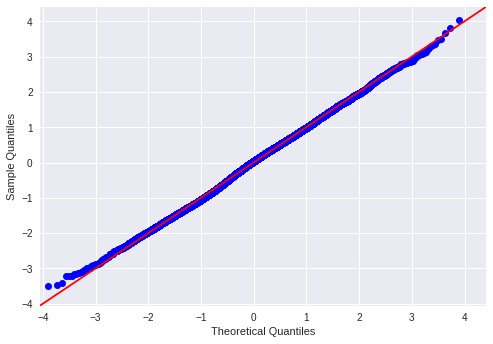

In [106]:
fig = sm.graphics.qqplot(ols_round_2.resid, dist=scs.norm, line='45', fit=True)

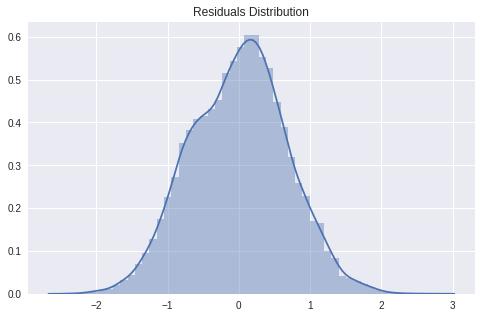

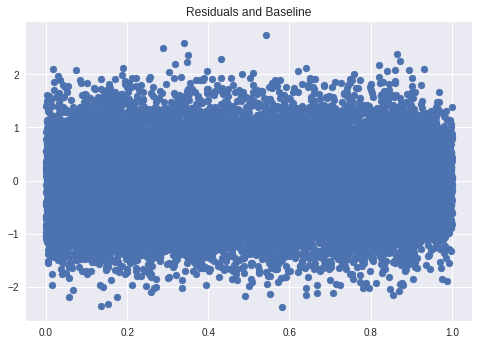

In [107]:
# Plot the residuals to get a visualization of residual distribution and if residuals are homoscedastic
plot_residuals(ols_round_2)

### Cross Validate in SciKitLearn
Use K-Fold Cross Validation to run multiple test/train splits. Are the R squared values consistent?

In [108]:
linear = LinearRegression(fit_intercept=False)
X = likely_features_df[likely_feature_names]
y = likely_features_df['price_log']
cross_val_score(linear, X, y, scoring='r2', n_jobs=-1, cv=5, verbose=1) # 5 fold split, 80 train/20 test

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


array([0.53743239, 0.52921281, 0.52453538, 0.54589867, 0.55511809])

#### The R Squared scores for the different splits do NOT vary too much. 
Let's go ahead with a train test split

### Train Test Split

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
linear.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [110]:
linear.coef_

array([ 0.11282601,  0.26707639, -0.04491996,  0.40877965, -0.12672498,
        0.35294775,  0.18969014,  0.43557634,  0.33876671,  0.39942532,
        0.78897041, -1.01479774, -0.93019765, -0.56389779, -0.26612689,
        0.09533143,  0.52786693,  0.838929  ,  1.03702038,  1.22863492])

#### Compare the coef values here with OLS model coef values  above  - They are pretty much the same.

#### Compare the Rsquared scores on the Train and Test models

In [111]:
linear.score(X_train, y_train), linear.score(X_test, y_test)

(0.5401906753636221, 0.5452743355598657)

# Model Evaluation

__From statsFunctions.py (from our cohort's Study Group)__
* test residuals distribution for normality Fusing the Shaprio Test Failed - this may be due to the dataset size of ~20,000 records.
* test Rediduals for homoscedasticity using the Breusch Pagan Test Failed - this may be due to the dataset size of ~20,000 records.
* The various plots for residucal distribution and homoscedasticity appeared resonable. Investigatig this could be done under Future Work.

__OLS Regression Results__
* R squared and Adjusted R squared
    * Both are __0.541__
* Omnibus/Prob(Omnibus) – a test of the skewness and kurtosis of the residual. We hope to see a value close to zero which would indicate normalcy. The Prob (Omnibus) performs a statistical test indicating the probability that the residuals are normally distributed. We hope to see something close to 1 here.
    * Omnibus is 30.29 and Prob(Omnibus) is 0.00. The histogram of the residual distributions appears to be normal so I'm really not sure how to interpreet these results.
* Skew – a measure of data symmetry. We want to see something close to zero, indicating the residual distribution is normal.
    * Skew is very close to zero, at -0.009, hardly any skew.
* Kurtosis – a measure of "peakiness", or curvature of the data. Higher peaks lead to greater Kurtosis. Greater Kurtosis can be interpreted as a tighter clustering of residuals around zero, implying a better model with few outliers.
    * Kurtosis is 2.83. I'm not entirely sure how to interpret this value/what does 'higher peak' mean?
 * Durbin-Watson – tests for homoscedasticity. We hope to have a value between 1 and 2. 
    * D-W is 1.975, within range as we can see from the residual plots below.
* Jarque-Bera(JB) – like the Omnibus test in that it tests both skew and kurtosis. We hope to see in this test a confirmation of the Omnibus test.
    * JB is 25.548 and is close to Ominbus result. I'm not entirely sure how to interpret this value.
* Condition Number – This test measures the sensitivity of a function's output as compared to its inpuput. When there is multicollinearity, we can expect much higher fluctuations to small changes in the data, hence, we hope to see a relatively small number, something below 30. 
    * Cond. No is 40.8, which is above 30. 

Big shoutout to Cohort Member, Andrea C., for sharing this great resource on understanding the LR results.  https://www.accelebrate.com/blog/interpreting-results-from-linear-regression-is-the-data-appropriate 


__Train/Test Splits__
* Consistant R squared scores so my model is not biased 
* After building our model in SciKitLearn, we get similar Rsquare values (__0.5401__ and __0.5452___) as the model created on the entire data set (OLS Regression results above with R squared and Adjusted R squared of __0.541__)
